# 1  Скачивание, обработка и визуализация данных

## Базовая настройка проекта

In [1]:
import numpy as np
from pyquery import PyQuery as pq
from matplotlib import pylab as plt

%matplotlib inline
%config InlineBackend.figure_format = "svg"
%config InlineBackend.close_figures = True

## Скачиваем данные за 1978  -- 2015

In [2]:
# Загрузка данных
def load_data(data_file: "html", ret_flag: int=0)->tuple:
    """
    Считывание данных из файла, удаление заголовков 
    и разбиение данных на дату и координаты
    """
    text = [item.text() for item in data_file.items("pre")]
    text = text[0].split()
    text = text[3:] # del table 
    del(text[2::3]) # del sigma from data
    
    date = np.array(text[0::2]).astype(float) # convert str to int
    
    data_value = np.array(text[1::2]).astype(float) # convert str value to float
    
    if ret_flag:
        return data_value, date
    return data_value

In [3]:
x_data = pq(filename="data_html/datax_1978.html")
y_data = pq(filename="data_html/datay_1978.html")

x_coord, date = load_data(x_data, 1)
y_coord = load_data(y_data)

### Построим полученные данные

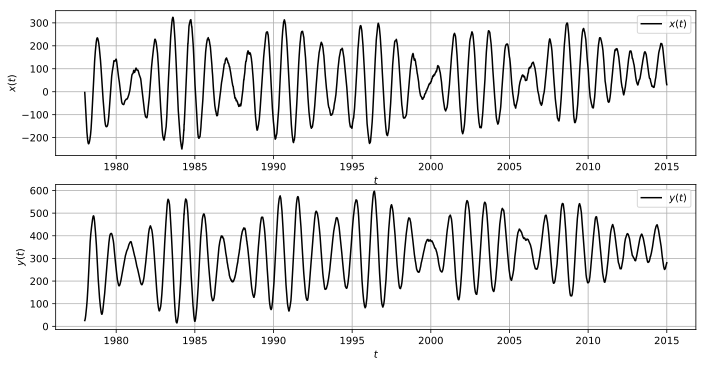

In [4]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$x(t)$")
plt.xlabel("$t$")
plt.plot(date, x_coord, color="black", label="$x(t)$")
plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$y(t)$")
plt.xlabel("$t$")
plt.plot(date, y_coord, color="black", label="$y(t)$")
plt.legend()

# plt.savefig("./figures/x_and_y.eps", format="eps")
plt.show()

##  Удаления тренда и гармоник с $h < 7 $ лет

In [5]:
# удалим тренд
A_coord = np.vstack([date, np.ones(len(date))]).T
a_x, b_x = np.linalg.lstsq(A_coord, x_coord, rcond=None)[0]
a_y, b_y = np.linalg.lstsq(A_coord, y_coord, rcond=None)[0]
print("a_x = {}, b_x = {}".format(a_x, b_x))
print("a_y = {}, b_y = {}".format(a_y, b_y))
trend_x = a_x * date + b_x
trend_y = a_y * date + b_y
detrend_x = x_coord - trend_x
detrend_y = y_coord - trend_y

a_x = 1.9936878932906148, b_x = -3931.7921571122347
a_y = 2.2488005758509213, b_y = -4168.697309332524


### Визуализируем тренд

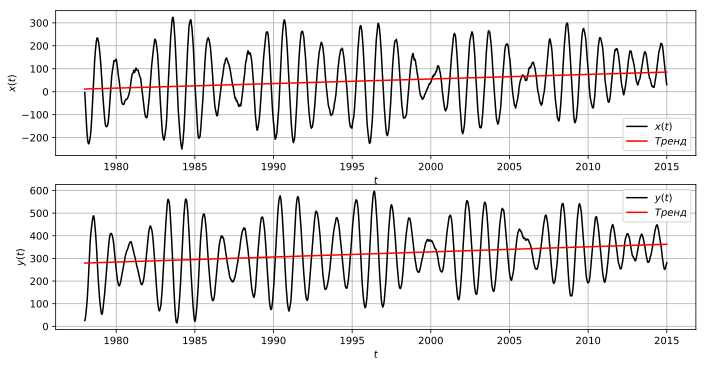

In [6]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$x(t)$")
plt.xlabel("$t$")
plt.plot(date, x_coord, color="black", label="$x(t)$")
plt.plot(date, trend_x, color="red", label="$Тренд$")
plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$y(t)$")
plt.xlabel("$t$")
plt.plot(date, y_coord, color="black", label="$y(t)$")
plt.plot(date, trend_y, color="red", label="$Тренд$")
plt.legend()

# plt.savefig("./figures/x_and_y_with_trend.eps", format="eps")
plt.show()

### Выгрузим данные для удаления шумов в Автосигнале

In [7]:
with open("data_txt/detrend_x_1.txt", 'w') as datatxt:
    for i in range(len(x_coord)) :
        print(date[i], '\t', detrend_x[i], file=datatxt)
with open("data_txt/detrend_y_1.txt", 'w') as datatxt:
    for i in range(len(y_coord)) :
        print(date[i], '\t', detrend_y[i], file=datatxt)

### Загружем отфильрованные данные

In [8]:
with open("data_txt/fx_1.txt", 'r') as data_x_txt:
    data = data_x_txt.read()
    data = data.split()
    filtred_x = np.array(data[1::2]).astype(np.float32)
    filtred_date = np.array(data[0::2]).astype(np.float32)
    print(filtred_x.shape, filtred_date.shape)
with open("data_txt/fy_1.txt", 'r') as data_y_txt:
    data = data_y_txt.read()
    data = data.split()
    filtred_y = np.array(data[1::2]).astype(np.float32)
    print(filtred_y.shape)

(13514,) (13514,)
(13514,)


### Построим отфильтованные данные

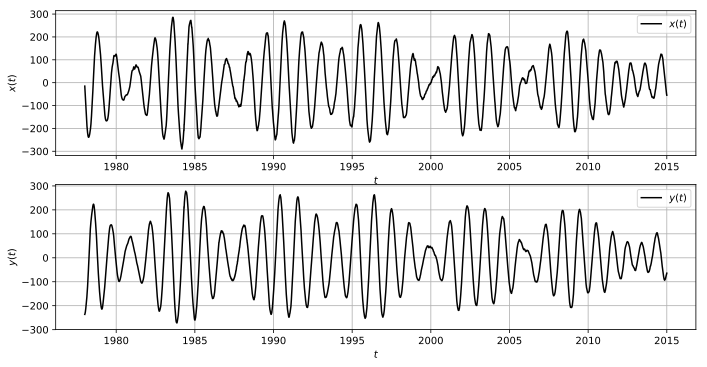

In [9]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$x(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, filtred_x, color="black", label="$x(t)$")
plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$y(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, filtred_y, color="black", label="$y(t)$")
plt.legend()
# plt.savefig("./figures/x_and_y_filtred.eps", format="eps")
plt.show()

# 2 Переходим к полярному углу

## Зададим функцию перехода 

In [10]:
def polar_coordinate_system(x: "np.array", y: "np.array"):
    r = np.sqrt(x ** 2 + y ** 2)
#     phi = [np.arctan(y[0] / x[0]) + np.pi]
    phi = [0]
    for i in range(len(r) - 1):
        delta_x = x[i + 1] - x[i]
        delta_y = y[i + 1] - y[i]
        delta_r = np.sqrt(delta_x ** 2 + delta_y ** 2)
        delta_phi = np.arccos(np.minimum(1,(r[i + 1] ** 2 + r[i] ** 2 - delta_r ** 2)/
                              (2 * r[i + 1] * r[i])))
        k = (x[i] * (y[i] - y[i - 1]) - y[i] * (x[i] - x[i - 1]))
        k /= np.abs(k)
        phi.append(phi[i] + delta_phi * k)

    return r, phi

## найдем пол-е коор-ы для наших обработанных данных

In [11]:
r, phi = polar_coordinate_system(filtred_x, filtred_y)
print(np.shape(r), np.shape(phi), np.shape(filtred_date))

(13514,) (13514,) (13514,)


### Визуализируем

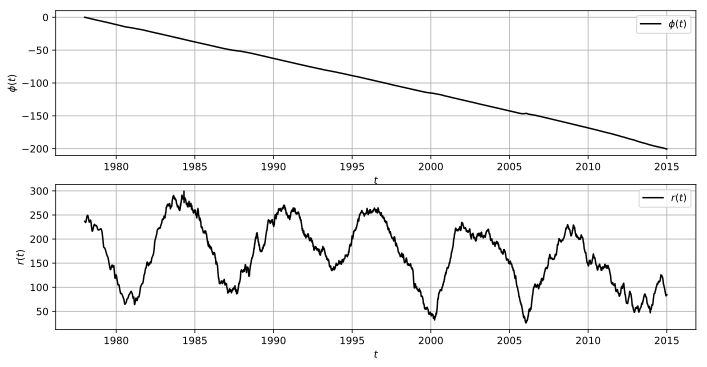

In [12]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, phi, color="black", label="$\phi(t)$")
plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$r(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, r, color="black", label="$r(t)$")
plt.legend()
# plt.savefig("./figures/polar.eps", format="eps")
plt.show()

## Удалим линейную состовляющую
$\phi(t)'= at + b$

In [13]:
A = np.vstack([filtred_date, np.ones(len(date))]).T
a, b = np.linalg.lstsq(A, phi, rcond=None)[0]
print("a = {}, b = {}".format(a, b))
trend = a * filtred_date + b
detrend_phi = phi - trend

a = -5.299376467883496, b = 10482.604419351686


### Визуализируем

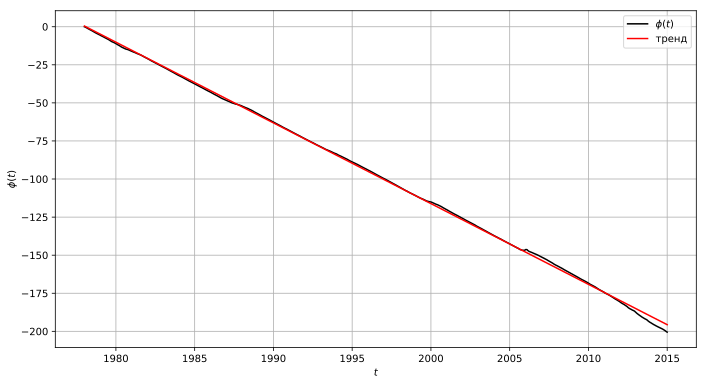

In [14]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, phi, color="black", label="$\phi(t)$")
plt.plot(filtred_date, trend, color="red", label="тренд")
plt.legend()
plt.show()

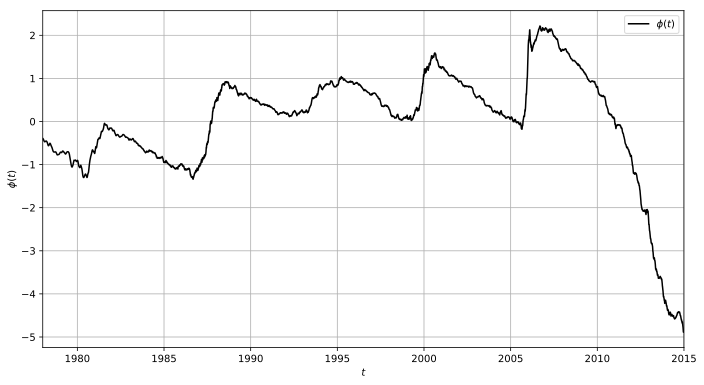

In [15]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(filtred_date[0], filtred_date[-1])
plt.plot(filtred_date, detrend_phi, color="black", label="$\phi(t)$")
plt.legend()
plt.show()

# 3 Построим модель перехода

## Начало

Переход произошел примерно в 2007 году. Поэтому для построения модели отбросим из начального $\phi(t)$ (с линейной частью) все позднее 2007г.

### Находим и визуализируем точку перехода

In [16]:
max_peak = np.max(detrend_phi)
max_peak_i = np.where(detrend_phi == max_peak)[0][0]
max_peak_date = filtred_date[max_peak_i]

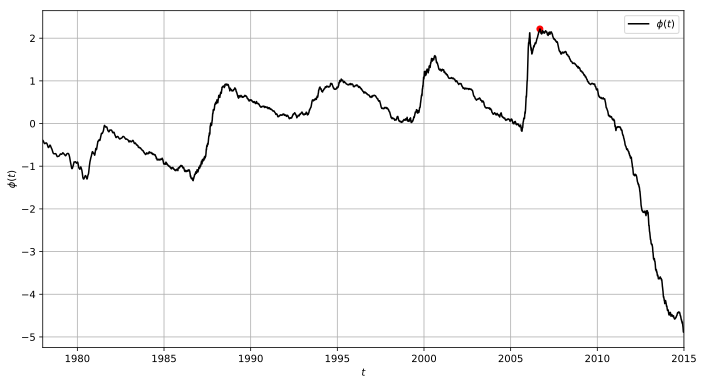

In [17]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(filtred_date[0], filtred_date[-1])
plt.plot(filtred_date, detrend_phi, color="black", label="$\phi(t)$")
plt.scatter(max_peak_date, max_peak, c="red")
plt.legend()
plt.show()

### Вырезаем данные до перехода

In [18]:
model_date = filtred_date[:max_peak_i]
model_phi = phi[:max_peak_i]

### Удалим линейную часть из $\phi(t)$

In [19]:
model_A = np.vstack([model_date, np.ones(len(model_date))]).T
model_a, model_b = np.linalg.lstsq(model_A, model_phi, rcond=None)[0]
print("a = {}, b = {}".format(model_a, model_b))
model_trend = model_a * model_date + model_b

a = -5.234587050651024, b = 10353.679665847387


In [20]:
detrend_model_phi = model_phi - model_trend

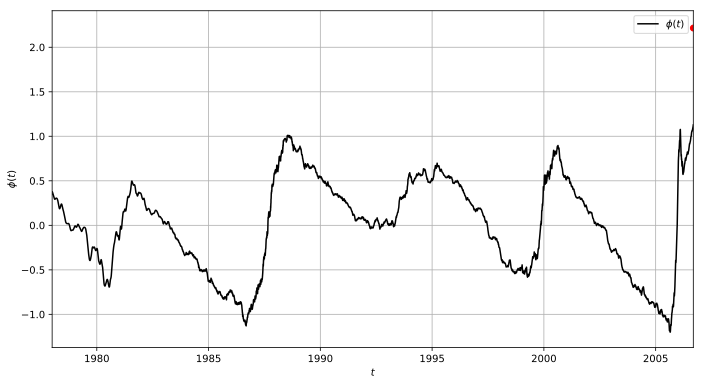

In [21]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, detrend_model_phi, color="black", label="$\phi(t)$")
plt.scatter(max_peak_date, max_peak, c="r")
plt.legend()
plt.show()

## Отфильруем сигнала, удалив частоты > 1 года

### Выгружаем нефильтр-е данные

In [22]:
with open("data_txt/model_phi_1.txt", 'w') as datatxt:
    for i in range(len(model_date)) :
        print(model_date[i], '\t', detrend_model_phi[i], file=datatxt)

### Загружем отфильрованные данные

In [23]:
with open("data_txt/fmphi.txt", 'r') as data_txt:
    data = data_txt.read()
    data = data.split()
    filtred_model_phi = np.array(data[1::2]).astype(np.float32)
    print(filtred_model_phi.shape, model_date.shape)

(10477,) (10477,)


### Выделим шум

In [24]:
model_noise = detrend_model_phi - filtred_model_phi

### Построим полученные данные

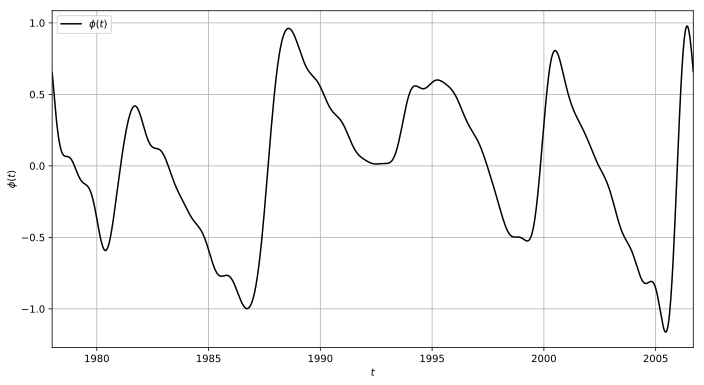

In [25]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, filtred_model_phi, color="black", label="$\phi(t)$")
plt.legend()
plt.show()

## Будем строить модель как отражение существ. данных и смещение на 1 - N

In [26]:
N = 0.85
bayes = 1 - N
bayes

0.15000000000000002

### Возможные точки с которых можно отражать данные

In [27]:
print(model_date[6500], model_date[7500])
inte = 6500, 7800

1995.7988 1998.5366


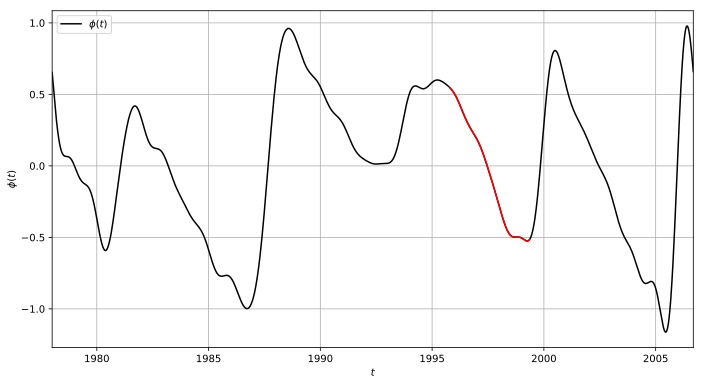

In [28]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, filtred_model_phi, color="black", label="$\phi(t)$")
plt.plot(model_date[inte[0]: inte[1]], filtred_model_phi[inte[0] : inte[1]], color="r")
plt.legend()
plt.show()

### Функция для создания новой модели

In [29]:
def newmodel(repoint, old_date, old_phi, df1=0, df2=0, inte=0, lel=0):
    new_date1 = old_date[:repoint]
    new_date2 = old_date[repoint:]
    tmp_ = new_date2.size
    new_phi1 = old_phi[:repoint]
    if lel:
        tmp_ = lel
    new_phi2 = old_phi[repoint:] - (1 - N) * (old_date[:tmp_] -  new_date1[0]) * np.pi * 2
    
#     print(new_date1.size, new_date2.size, new_phi1.size, new_phi2.size )
    
    if df1:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,1)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(new_date1, new_phi1, color="black", label="$\phi(t)$")
        plt.plot(new_date2, new_phi2, color="red", label="$\phi(t)$")
        if df2:
            plt.subplot(3,1,2)
            plt.grid(True)
            plt.ylabel("$\phi(t)$")
            plt.xlabel("$t$")
            plt.xlim(old_date[0], old_date[-1])
            plt.plot(old_date, old_phi, color="black", label="$\phi(t)$")
            plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="y")
            plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
            plt.legend()
            
        plt.legend()
        plt.show()
    
    return np.concatenate([new_date1, new_date2]), np.concatenate([new_phi1, new_phi2])

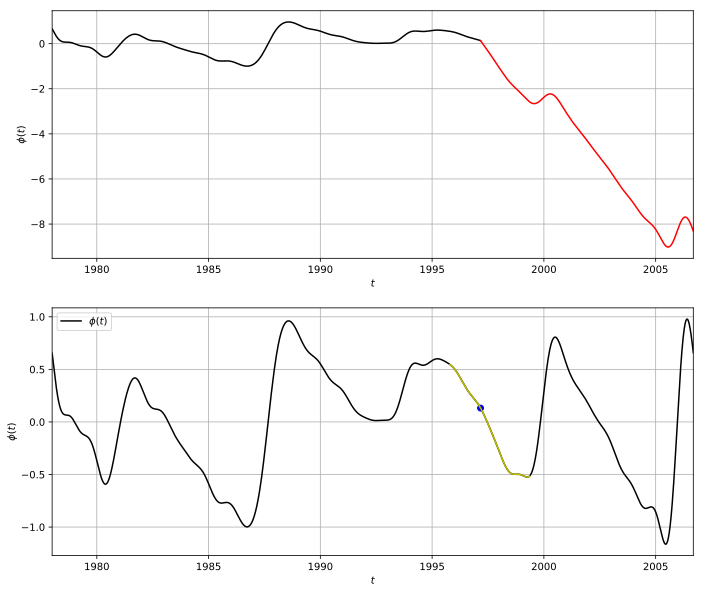

In [30]:
repoint = 7000
mod_t1, mod_phi1 = newmodel(repoint, model_date, filtred_model_phi, 1, 1, inte)

### Функция поиска точки частотного перехода

In [31]:
def find_max_delta(repoint, t, phi, length, h):
    new_t = t[:repoint]
    new_p = phi[:repoint]
    n = (new_t.size - length) // h
    a = []
    b = []
    res = []
    delta = []
    T = []
    PHI = []
    
    for i in range(n):
        t_ = np.array(new_t[i * h : length + i * h])
        T.append(t_)
        phi_ = np.array(new_p[i * h : length + i * h])
        PHI.append(phi_)

        A_ = np.vstack([T[i], np.ones(len(T[i]))]).T
        a_, b_ = np.linalg.lstsq(A_, PHI[i], rcond=None)[0]

        a.append(a_)
        b.append(b_)

        res_ = a_ * T[i] + b_

        res.append(res_)
        delta.append(a_)
        
    return np.max(np.abs(delta))  

### Функция поиска точки перехода

In [32]:
def find_ppoint(repoint, t, phi, length, h, delta, df1=0, df2=0, old_date=None, old_phi=None,  inte = 0, df3=0):
    t_ex_ch = t[repoint]
    a = []
    b = []
    res = []
    
    n = (t.size - length) // h
    mmin = 5
    T = []
    PHI = []
    
    for i in range(n):
        t_ = np.array(t[i * h : length + i * h])
        T.append(t_)
        phi_ = np.array(phi[i * h : length + i * h])
        PHI.append(phi_)

        A_ = np.vstack([T[i], np.ones(len(T[i]))]).T
        a_, b_ = np.linalg.lstsq(A_, PHI[i], rcond=None)[0]

        a.append(a_)
        b.append(b_)

        res_ = a_ * T[i] + b_

        res.append(res_)
        if np.abs(a[i]) > delta:
            t_ch = t[length + i * h] 
            ind_ch = length + i * h
            
            if t_ch - t_ex_ch < mmin:
                mmin = t_ch - t_ex_ch
                mmin_i = i
          
    print("Точка перехода известная: %.4f"%t_ex_ch)
    print("Точка перехода alg: %.4f"%t[length + mmin_i * h])
    print("отклонение от точки перехода {}".format(mmin))
    print("\n")
    
    if df1:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,1)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(t[0], t[-1])
        plt.plot(t, phi, color="black", label="$\phi(t)$", alpha=0.2)
        plt.plot(T[mmin_i], res[mmin_i], "red")
        plt.scatter(t[repoint], phi[repoint], c="b", alpha=1)
        plt.scatter(t[length + mmin_i * h], phi[length + mmin_i * h], c="gold", alpha=1)
        if df2:
            plt.subplot(3,1,2)
            plt.grid(True)
            plt.ylabel("$\phi(t)$")
            plt.xlabel("$t$")
            plt.xlim(old_date[0], old_date[-1])
            plt.plot(old_date, old_phi, color="black", label="$\phi(t)$", alpha=0.2)
            plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
            plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
            plt.scatter(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], c="gold", alpha=1)
            plt.legend()
    if df3:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,2)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(old_date, old_phi, color="black", label="$\phi(t)$", alpha=0.2)
        plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
        plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
        plt.scatter(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], c="gold", alpha=1)
    
    return t_ch - t_ex_ch

### Находим точку перехода

In [33]:
length = 365 * 4
h = 1

In [34]:
delta1 = find_max_delta(repoint, mod_t1, mod_phi1, length, h)
print(delta1)

0.6105757451277634


Точка перехода известная: 1997.1677
Точка перехода alg: 1998.6790
отклонение от точки перехода 1.51123046875




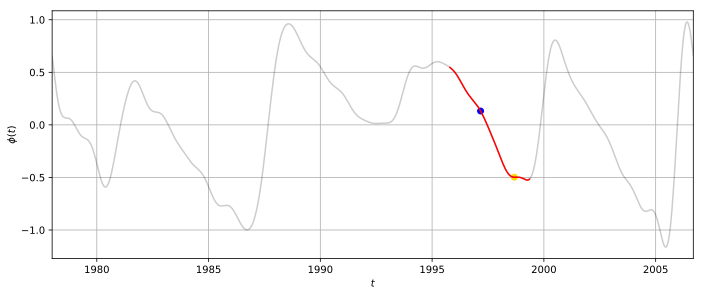

In [35]:
res1 = find_ppoint(repoint, mod_t1, mod_phi1, length, h, delta1, 0, 0, model_date, filtred_model_phi, inte,1)

### Статистика


Точка перехода известная: 1995.7988
Точка перехода alg: 1997.7673
отклонение от точки перехода 1.968505859375


Точка перехода известная: 1996.0726
Точка перехода alg: 1997.9398
отклонение от точки перехода 1.8671875


Точка перехода известная: 1996.3463
Точка перехода alg: 1998.1205
отклонение от точки перехода 1.774169921875


Точка перехода известная: 1996.6201
Точка перехода alg: 1998.3040
отклонение от точки перехода 1.683837890625


Точка перехода известная: 1996.8939
Точка перехода alg: 1998.4901
отклонение от точки перехода 1.59619140625


Точка перехода известная: 1997.1677
Точка перехода alg: 1998.6790
отклонение от точки перехода 1.51123046875


Точка перехода известная: 1997.4415
Точка перехода alg: 1998.8871
отклонение от точки перехода 1.445556640625


Точка перехода известная: 1997.7153
Точка перехода alg: 1999.1226
отклонение от точки перехода 1.4072265625


Точка перехода известная: 1997.9890
Точка перехода alg: 1999.3962
отклонение от точки перехода 1.4072265625


Точ

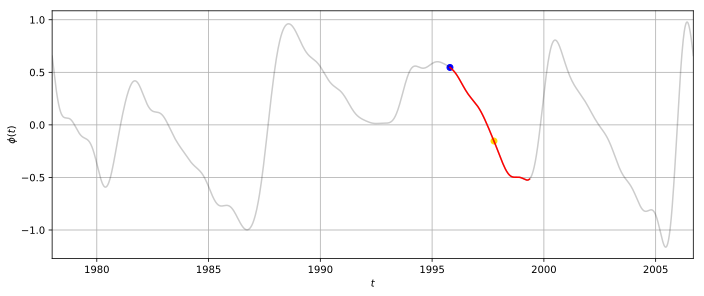

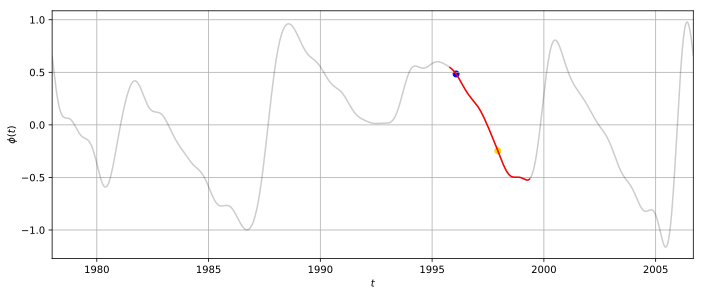

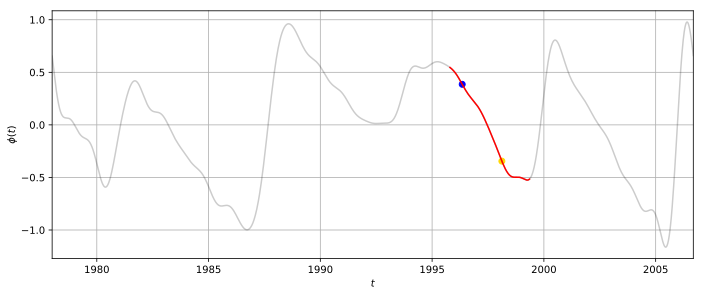

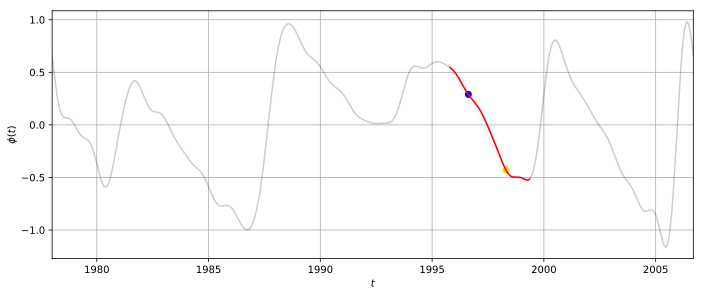

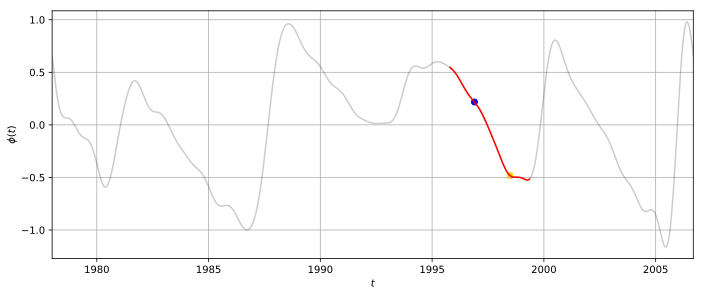

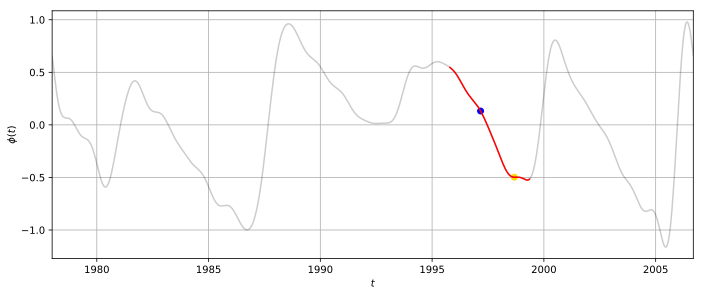

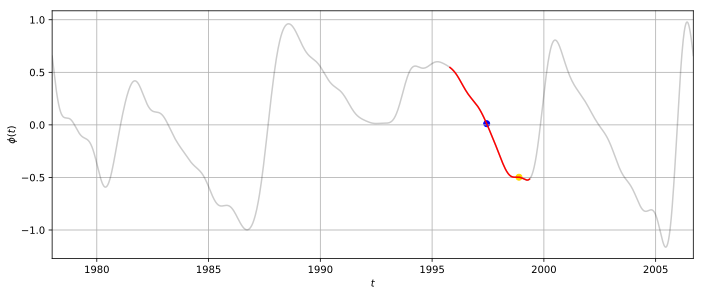

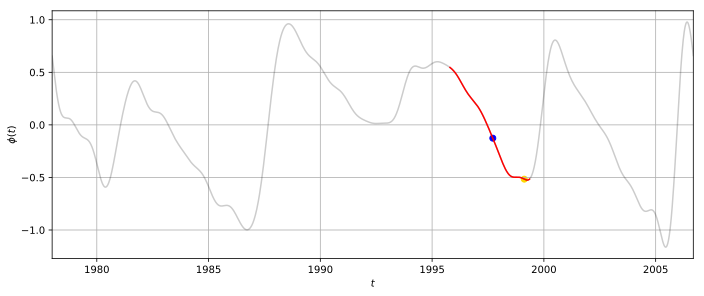

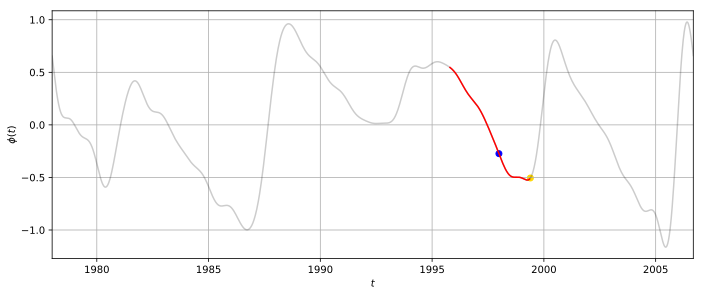

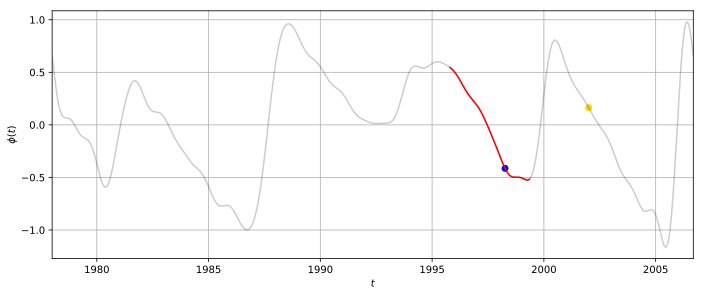

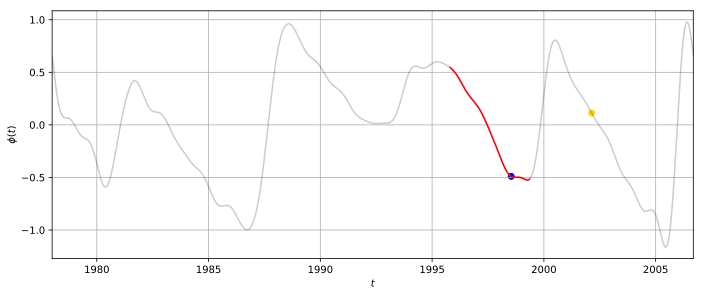

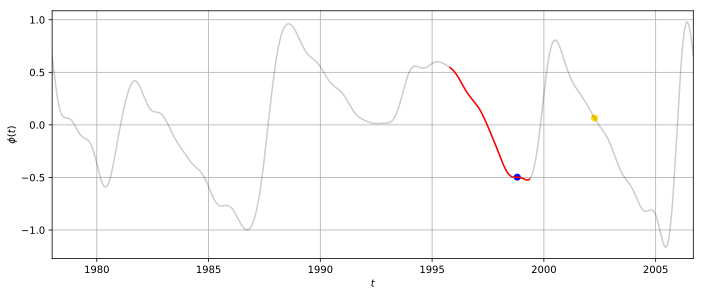

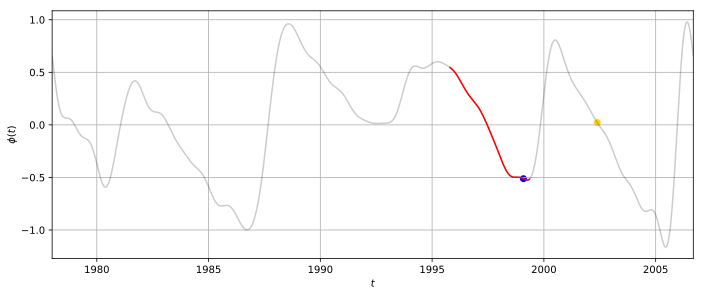

In [36]:
length = 365 * 4
h = 1
l = 100
for repoint in range(inte[0], inte[1], l):
    mod_t1, mod_phi1 = newmodel(repoint, model_date, filtred_model_phi, 0, 0, inte)
    delta1 = find_max_delta(repoint, mod_t1, mod_phi1, length, h)
    so = find_ppoint(repoint, mod_t1, mod_phi1, length, h, delta1, 0, 0, model_date, filtred_model_phi, inte, 1)

# Проверка алгоритма для 2х других интервалов

## 2

In [37]:
print(model_date[3900], model_date[5400])
inte = 3900, 5400

1988.6804 1992.7871


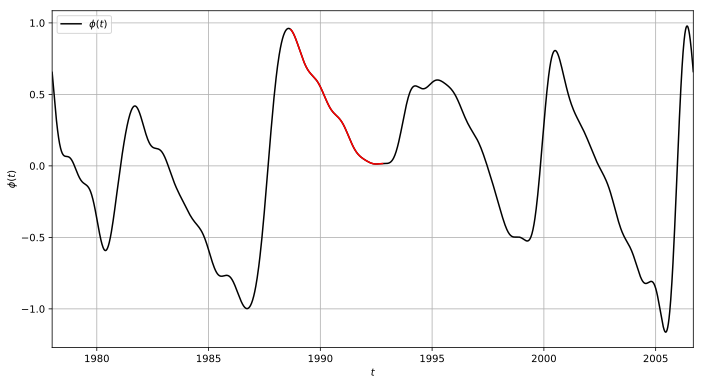

In [38]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, filtred_model_phi, color="black", label="$\phi(t)$")
plt.plot(model_date[inte[0]:inte[1]], filtred_model_phi[inte[0]:inte[1]], color="r")
plt.legend()
plt.show()

### Проверка

Точка перехода известная: 1988.6804
Точка перехода alg: 1988.6804
отклонение от точки перехода 0.0


Точка перехода известная: 1988.9541
Точка перехода alg: 1988.9541
отклонение от точки перехода 0.0


Точка перехода известная: 1989.2279
Точка перехода alg: 1989.2279
отклонение от точки перехода 0.0


Точка перехода известная: 1989.5017
Точка перехода alg: 1989.5017
отклонение от точки перехода 0.0


Точка перехода известная: 1989.7755
Точка перехода alg: 1991.7057
отклонение от точки перехода 1.93017578125


Точка перехода известная: 1990.0493
Точка перехода alg: 1991.8508
отклонение от точки перехода 1.801513671875


Точка перехода известная: 1990.3231
Точка перехода alg: 1992.0260
отклонение от точки перехода 1.702880859375


Точка перехода известная: 1990.5969
Точка перехода alg: 1992.2450
отклонение от точки перехода 1.6480712890625


Точка перехода известная: 1990.8706
Точка перехода alg: 1992.5298
отклонение от точки перехода 1.6591796875


Точка перехода известная: 1991.1444
То

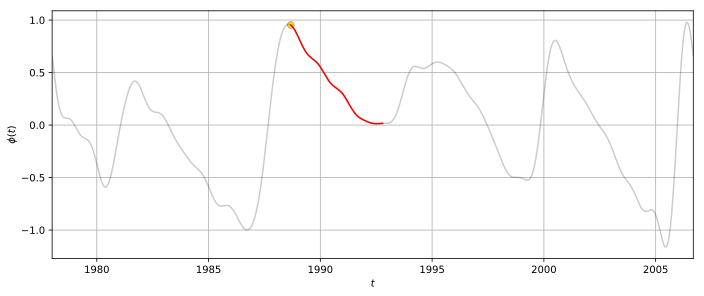

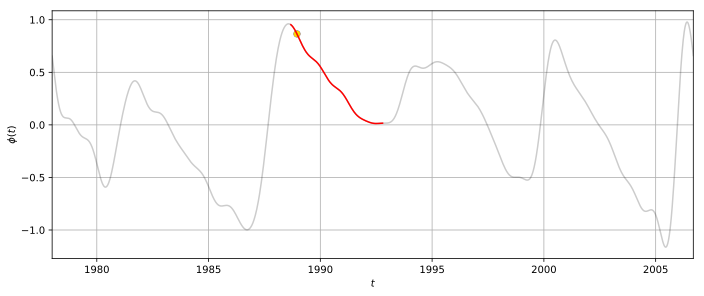

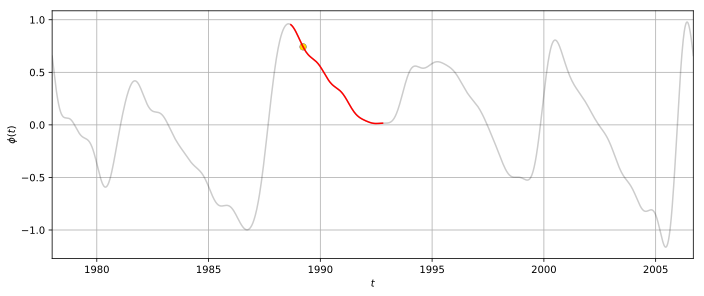

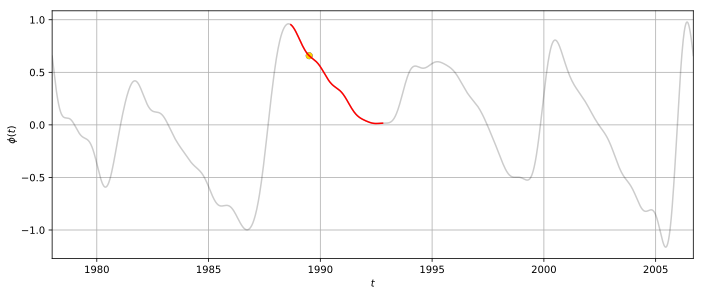

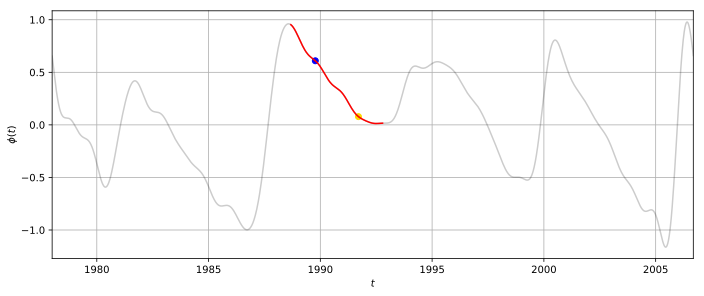

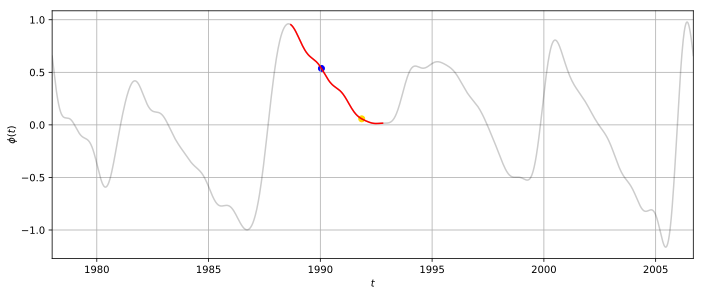

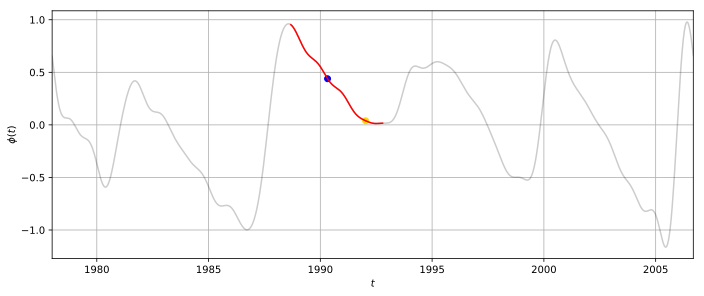

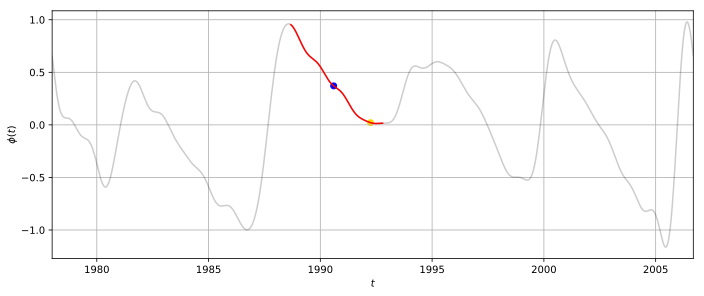

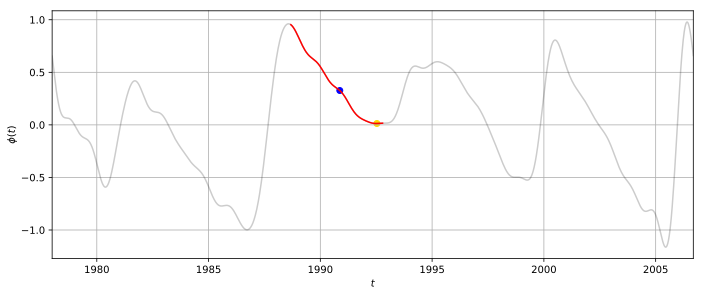

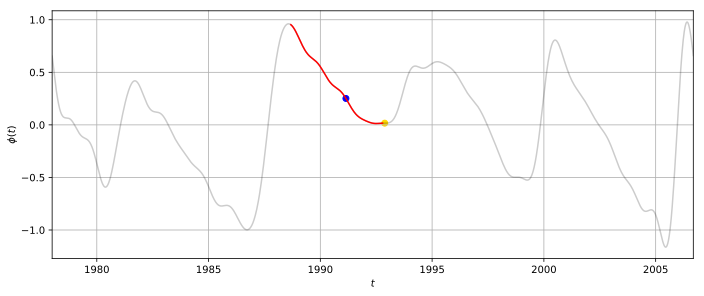

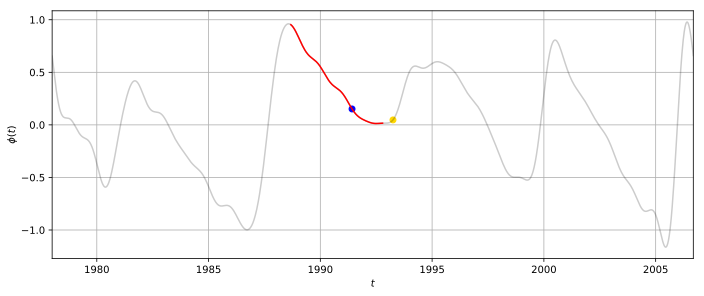

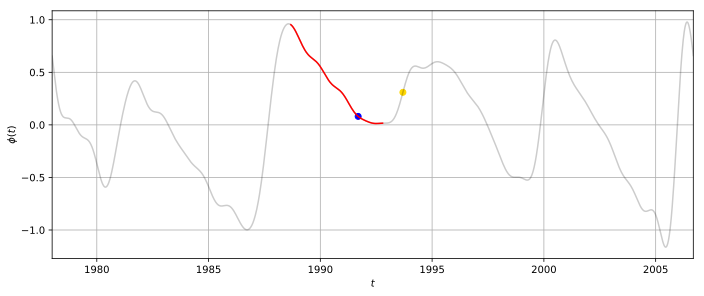

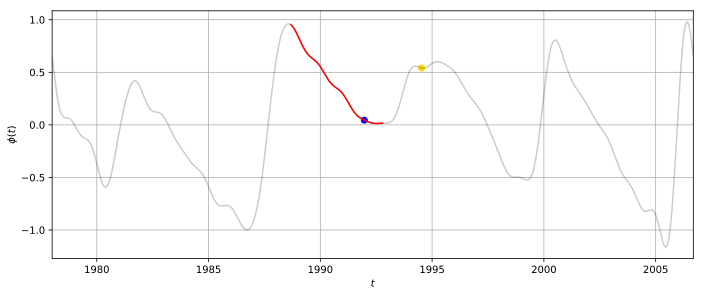

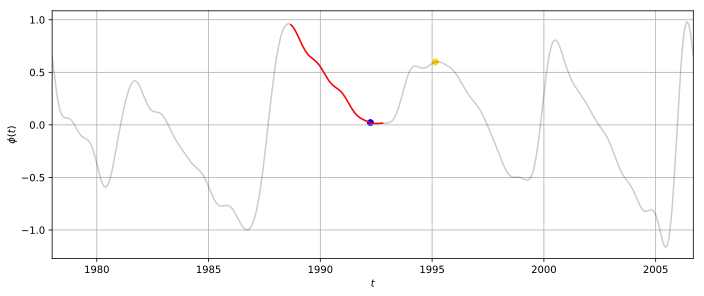

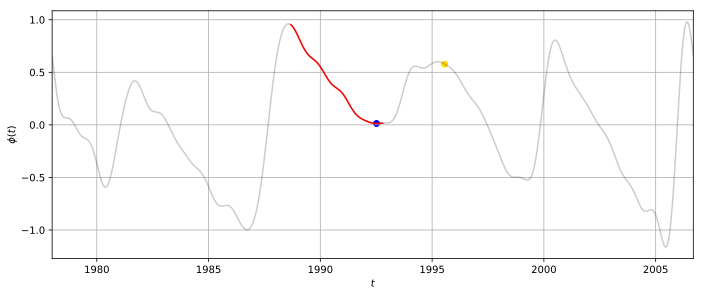

In [39]:
length = 365 * 4
h = 1
l = 100
for repoint in range(inte[0], inte[1], l):
    mod_t1, mod_phi1 = newmodel(repoint, model_date, filtred_model_phi, 0, 0, inte)
    delta1 = find_max_delta(repoint, mod_t1, mod_phi1, length, h)
    so = find_ppoint(repoint, mod_t1, mod_phi1, length, h, delta1, 0, 0, model_date, filtred_model_phi, inte, 1)

## 1

In [57]:
print(model_date[1400], model_date[3200])
inte = 1500, 3200

1981.8357 1986.7639


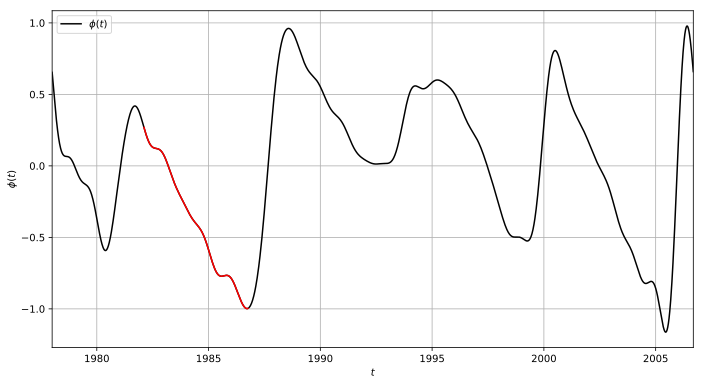

In [58]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, filtred_model_phi, color="black", label="$\phi(t)$")
plt.plot(model_date[inte[0]:inte[1]], filtred_model_phi[inte[0]:inte[1]], color="r")
plt.legend()
plt.show()

### Проверка

Точка перехода известная: 1982.1095
Точка перехода alg: 1982.1095
отклонение от точки перехода 0.0


Точка перехода известная: 1982.3833
Точка перехода alg: 1982.3833
отклонение от точки перехода 0.0


Точка перехода известная: 1982.6571
Точка перехода alg: 1982.6571
отклонение от точки перехода 0.0


Точка перехода известная: 1982.9309
Точка перехода alg: 1982.9309
отклонение от точки перехода 0.0


Точка перехода известная: 1983.2047
Точка перехода alg: 1984.2751
отклонение от точки перехода 1.0704345703125


Точка перехода известная: 1983.4784
Точка перехода alg: 1984.3901
отклонение от точки перехода 0.9117431640625


Точка перехода известная: 1983.7522
Точка перехода alg: 1984.4969
отклонение от точки перехода 0.7447509765625


Точка перехода известная: 1984.0260
Точка перехода alg: 1984.5927
отклонение от точки перехода 0.566650390625


Точка перехода известная: 1984.2998
Точка перехода alg: 1984.6749
отклонение от точки перехода 0.3751220703125


Точка перехода известная: 1984.5

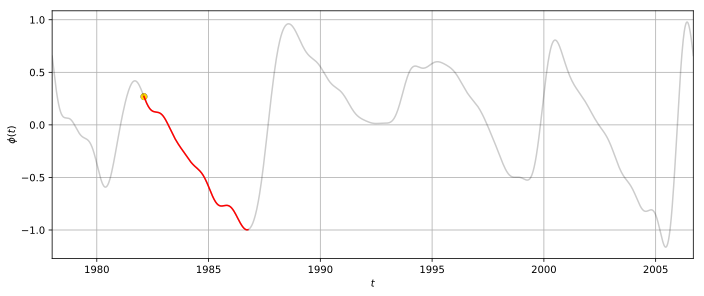

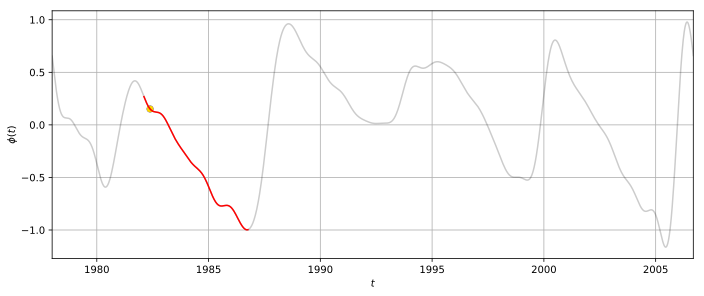

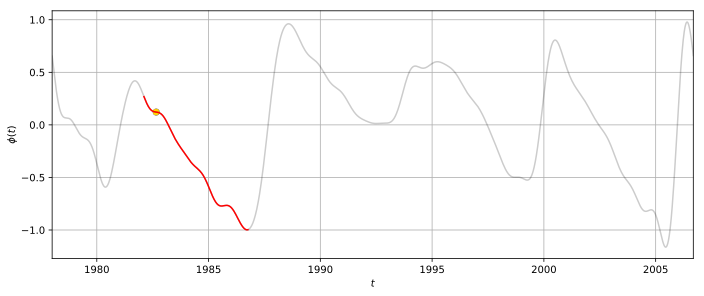

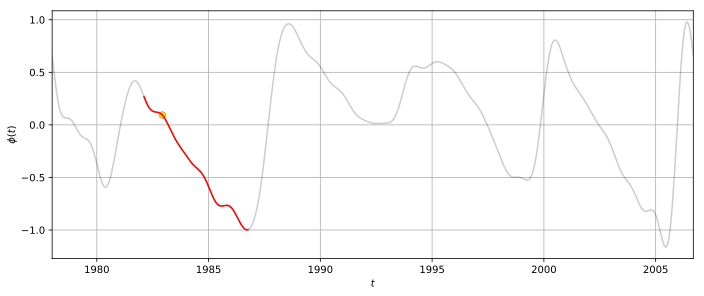

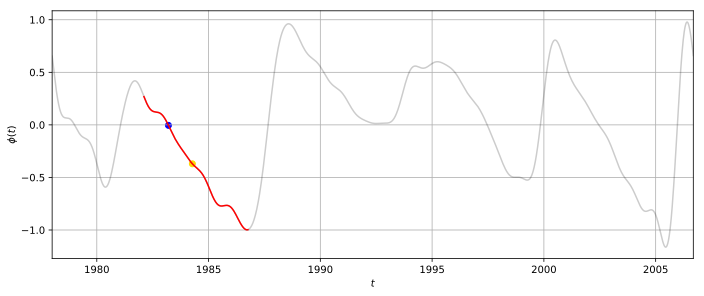

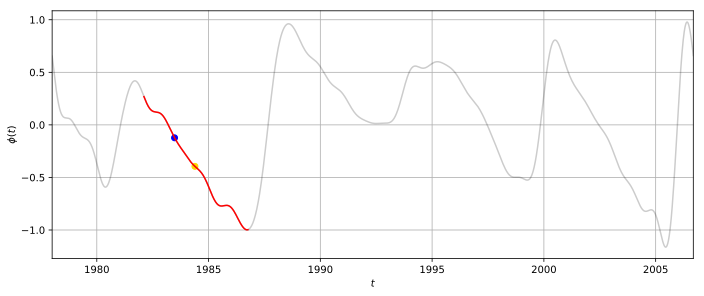

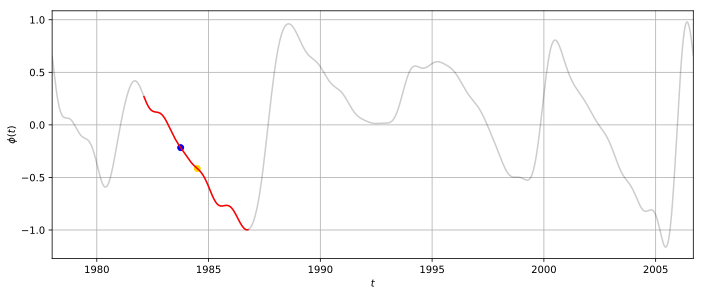

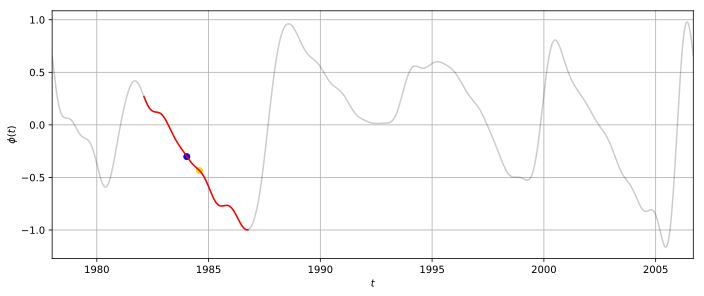

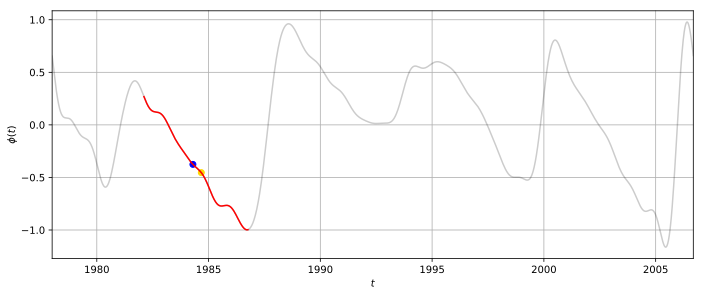

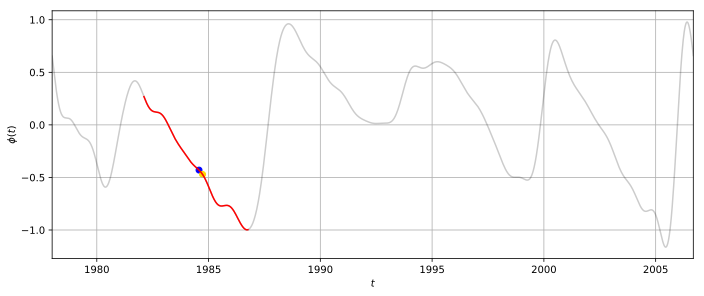

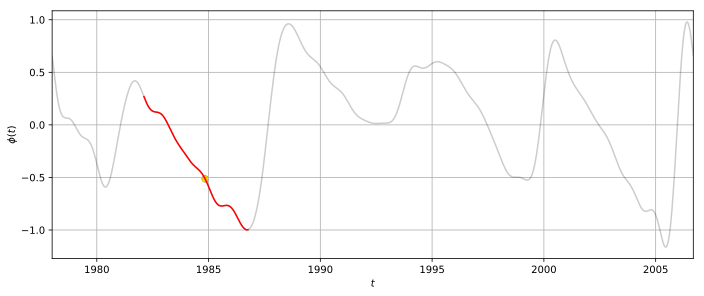

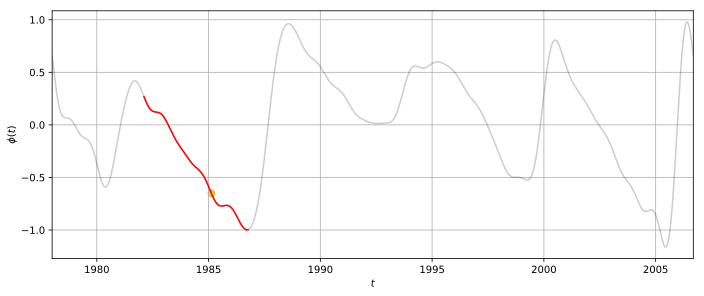

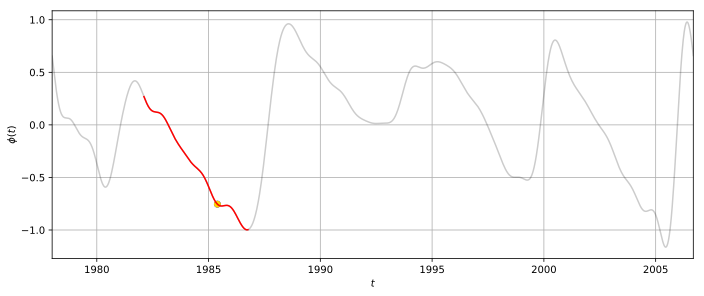

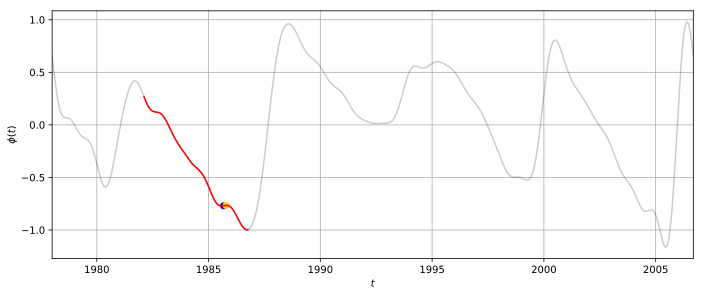

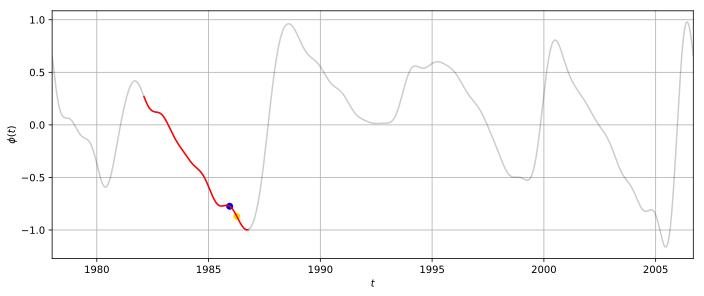

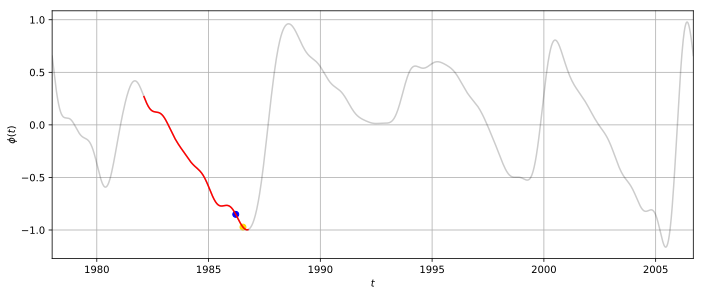

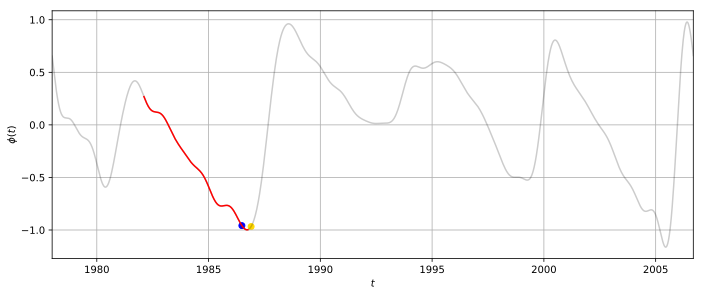

In [59]:
length = 365 * 4
h = 1
# l = 100
for repoint in range(inte[0], inte[1], l):
# repoint = 1500
    mod_t1, mod_phi1 = newmodel(repoint, model_date, filtred_model_phi, 0, 0, inte)
    delta1 = find_max_delta(repoint, mod_t1, mod_phi1, length, h)
    so = find_ppoint(repoint, mod_t1, mod_phi1, length, h, delta1, 0, 0, model_date, filtred_model_phi, inte, 1)